# Imports

In [187]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import re
import time
from sklearn.impute import KNNImputer
import scipy.stats as stats

start_time = time.time()


chunksize = 10 ** 3  # Chunksize de 1000 lignes
filename = 'products.csv'
nan_rates = []

try:
    reader = pd.read_csv(filename, chunksize=chunksize, sep='\t')

    for chunk in reader:
        nan_rates.append(chunk.isna().mean(axis=0))

except pd.errors.ParserError as e:
    print(f"ParserError: {e}")

# Calcul des taux moyens de remplissage des chunks
if nan_rates:
    inds_nan_rate = pd.concat(nan_rates, axis=1).mean(axis=1)
    cols_to_load = inds_nan_rate[inds_nan_rate < 0.7].index.tolist()

    # Chargement des données filtrées
    df = pd.read_csv(filename, sep='\t', usecols=cols_to_load)
    df = df.drop(['url','states','additives_n','nutrition-score-fr_100g','energy_100g','main_category','completeness','nutrient_levels_tags','brands','nova_group','food_groups','categories','creator','serving_size','serving_quantity','categories','image_nutrition_url','ingredients_analysis_tags','ingredients_tags','ingredients_text','image_nutrition_small_url','created_datetime','food_groups_tags','food_groups_en','states_tags','sodium_100g','states_en','last_image_datetime','last_modified_t','last_modified_datetime','created_t','last_modified_by','main_category_en','image_url','image_small_url','last_updated_t','last_image_t','brands_tags','last_updated_datetime','categories_en','categories_tags','countries_tags','countries_en'], axis=1)

# Remplacer les valeurs NaN par une chaîne vide pour éviter les erreurs de filtrage
df['countries'].fillna('', inplace=True)  

# Liste des mots clés à rechercher dans la colonne 'countries'
keywords = ['France', 'French', 'Francia', 'Frankreich', 'Polynésie française', 'FR', 'fr']

# Filtrer les lignes où 'countries' ne contient pas les mots clés spécifiés
mask = df['countries'].str.contains('|'.join(keywords), case=False, na=False)
df = df[mask]

ParserError: Error tokenizing data. C error: Expected 206 fields in line 1537879, saw 234



/var/folders/25/t6v1433n06x6vfl9wjbxn8sw0000gn/T/ipykernel_1681/2879549298.py:34: DtypeWarning: Columns (0,50,52,56,58,88,89,91,92) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, sep='\t', usecols=cols_to_load)


# Informations Dataframe

In [189]:
df.info

<bound method DataFrame.info of                          code                  product_name        countries  \
0           00000000000000225                jeunes pousses        en:france   
3        00000000000026772226                          Skyr           France   
4               0000000000017              Vitória crackers           France   
5               0000000000031                         Cacao           France   
11              0000000000100   moutarde au moût de raisin            France   
...                       ...                           ...              ...   
3307643              99999995                Steak haché 5%           France   
3307647         9999999905667                           NaN  en:South Africa   
3307649         9999999916298       Beurre de cacahuète bio            en:fr   
3307652             999999999       Thé noir BIO Darjeeling        en:france   
3307657         9999999999994     Light & Free SKYR A BOIRE        en:france   

       

In [190]:
df.head(5)

,code,product_name,countries,nutriscore_score,nutriscore_grade,pnns_groups_1,pnns_groups_2,ecoscore_grade,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
0,00000000000000225,jeunes pousses,en:france,NaN,unknown,Fruits and vegetables,Vegetables,b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00000000000026772226,Skyr,France,-5.00,a,Milk and dairy products,Dairy desserts,b,57.00,0.20,0.10,3.90,3.90,NaN,10.00,0.09,NaN
4,0000000000017,Vitória crackers,France,NaN,unknown,unknown,unknown,unknown,375.00,7.00,3.08,70.10,15.00,NaN,7.80,1.40,NaN
5,0000000000031,Cacao,France,NaN,unknown,unknown,unknown,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,0000000000100,moutarde au moût de raisin,France,18.00,d,Fat and sauces,Dressings and sauces,c,NaN,8.20,2.20,29.00,22.00,0.00,5.10,4.60,0.00


In [191]:
df.dtypes

code                                                      object
product_name                                              object
countries                                                 object
nutriscore_score                                          object
nutriscore_grade                                          object
pnns_groups_1                                             object
pnns_groups_2                                             object
ecoscore_grade                                            object
energy-kcal_100g                                          object
fat_100g                                                  object
saturated-fat_100g                                        object
carbohydrates_100g                                       float64
sugars_100g                                              float64
fiber_100g                                               float64
proteins_100g                                            float64
salt_100g                

In [192]:
df.isna().sum()

code                                                          0
product_name                                              35036
countries                                                     0
nutriscore_score                                         657501
nutriscore_grade                                           9708
pnns_groups_1                                              1044
pnns_groups_2                                              1042
ecoscore_grade                                             1240
energy-kcal_100g                                         278680
fat_100g                                                 262330
saturated-fat_100g                                       259299
carbohydrates_100g                                       262180
sugars_100g                                              259558
fiber_100g                                               797971
proteins_100g                                            260593
salt_100g                               

# Fonction Nettoyage Données

In [194]:
def clean_and_impute_data(df):
    
    def detect_and_remove_cyrillic(df, column):
        cyrillic_pattern = re.compile(r'[\u0400-\u04FF]+')
        cyrillic_indices = df[df[column].apply(lambda x: bool(cyrillic_pattern.search(str(x))))].index
        df.drop(cyrillic_indices, inplace=True)
        df.reset_index(drop=True, inplace=True)
        print(f"\nNombre de lignes supprimées : {len(cyrillic_indices)}")
        print("Étape de suppression des caractères cyrilliques complétée.")
    
    def redistribute_nutrient_values(row, columns_to_check, max_sum=100):
        total = row[columns_to_check].sum()
        if total > max_sum:
            factor = max_sum / total
            row[columns_to_check] *= factor
        return row
    
    def check_nutrient_sum(df):
        columns_to_check = ['fat_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'carbohydrates_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g']
        nutrient_sum = df[columns_to_check].sum(axis=1)
        rows_with_high_sum = df[nutrient_sum > 100].copy()
        
        for idx, row in rows_with_high_sum.iterrows():
            df.loc[idx, columns_to_check] = redistribute_nutrient_values(row, columns_to_check)
        
        count_high_sum = rows_with_high_sum.shape[0]
        
        if count_high_sum > 0:
            print(f"\nNombre de lignes avec une somme strictement supérieure à 100 : {count_high_sum}")
        else:
            print("Aucune ligne avec une somme des colonnes strictement supérieure à 100 trouvée.")
        
        return count_high_sum
    
    # Suppression cyrillique
    detect_and_remove_cyrillic(df, 'product_name')
    
    # Suppression des doublons basés sur le code
    df.drop_duplicates(subset='code', inplace=True)
    print("Étape de suppression des doublons basée sur le code complétée.")
    
    # Suppression des lignes avec des valeurs NaN dans 'product_name'
    df.dropna(subset=['product_name'], inplace=True)
    print(f"\nNombre de lignes supprimées avec NaN dans 'product_name': {df.shape[0] - df.dropna(subset=['product_name']).shape[0]}")
    print("Étape de suppression des lignes avec des NaN dans 'product_name' complétée.")
    
    # Remplacement des valeurs >100 par la moyenne en fonction du 'product_name'
    columns_to_check = [
        'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
        'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 
        'fruits-vegetables-nuts-estimate-from-ingredients_100g'
    ]
    
    df[columns_to_check] = df[columns_to_check].apply(pd.to_numeric, errors='coerce')
    means = df.groupby('product_name')[columns_to_check].transform('mean')
    
    for column in columns_to_check:
        df[column] = np.where(df[column] > 100, means[column], df[column])
    
    values_above_100 = df[columns_to_check] > 100
    count_above_100 = values_above_100.sum().sum()
    print(f"Nombre de valeurs supérieures à 100 après correction : {count_above_100}")
    
    df.drop(index=df[values_above_100.any(axis=1)].index, inplace=True)
    print("Étape de remplacement des valeurs >100 par la moyenne complétée.")
    
    # Suppression des lignes où 'carbohydrates_100g' ou 'fruits-vegetables-nuts-estimate-from-ingredients_100g' sont supérieurs à 100
    df = df[(df['carbohydrates_100g'] <= 100) & (df['fruits-vegetables-nuts-estimate-from-ingredients_100g'] <= 100)]
    print(f"\nNombre de lignes supprimées où 'carbohydrates_100g' ou 'fruits-vegetables-nuts-estimate-from-ingredients_100g' sont supérieurs à 100 : {df.shape[0] - df[(df['carbohydrates_100g'] <= 100) & (df['fruits-vegetables-nuts-estimate-from-ingredients_100g'] <= 100)].shape[0]}")
    
    # Imputation itérative des NaN
    imputer = IterativeImputer(max_iter=50, tol=0.001, sample_posterior=True, random_state=0)
    df[columns_to_check] = df[columns_to_check].clip(0, 900).round(2)
    df_imputed = imputer.fit_transform(df[columns_to_check])
    df[columns_to_check] = df_imputed
    
    print("Étape d'imputation itérative des NaN complétée.")
    
    # Suppression des lignes avec des valeurs négatives
    negative_values = {}
    for column in columns_to_check:
        count_negatives = df[df[column] < 0].shape[0]
        if count_negatives > 0:
            negative_values[column] = count_negatives
            df = df[df[column] >= 0]
    
    print("\nRésumé des lignes supprimées contenant des valeurs négatives :")
    for column, count in negative_values.items():
        print(f"Colonne '{column}': {count} lignes supprimées contenant des valeurs négatives")
    print("Étape de suppression des lignes avec des valeurs négatives complétée.")
    
    # Suppression des lignes où 'energy-kcal_100g' est supérieur à 900
    df['energy-kcal_100g'] = pd.to_numeric(df['energy-kcal_100g'], errors='coerce')
    high_energy_rows = df[df['energy-kcal_100g'] > 900]
    print(f"Nombre de lignes où 'energy-kcal_100g' est supérieur à 900 : {high_energy_rows.shape[0]}")
    df.drop(index=high_energy_rows.index, inplace=True)
    
    print("Étape de suppression des lignes où 'energy-kcal_100g' est supérieur à 900 complétée.")
    
    # Redistribution des valeurs si la somme des colonnes dépasse 100
    modified_counter = check_nutrient_sum(df)
    print(f"\nNombre de valeurs modifiées pendant la redistribution : {modified_counter}")
    print("Étape de redistribution des valeurs complétée.")
    
    # Conversion de nutriscore_score en numérique
    df['nutriscore_score'] = pd.to_numeric(df['nutriscore_score'], errors='coerce')
    
    # Imputation des NaN dans 'nutriscore_score' par la médiane en fonction de 'product_name'
    initial_nan_count_nutriscore = df['nutriscore_score'].isna().sum()
    df['nutriscore_score'] = df.groupby('product_name')['nutriscore_score'].transform(lambda x: x.fillna(x.median()))
    final_nan_count_nutriscore = df['nutriscore_score'].isna().sum()
    modified_nutriscore_count = initial_nan_count_nutriscore - final_nan_count_nutriscore
    
    print(f"Nombre de valeurs modifiées (nutriscore_score) : {modified_nutriscore_count}")

    # Imputation itérative en utilisant d'autres colonnes pour guider l'imputation
    imputer = IterativeImputer(max_iter=100, random_state=10, min_value=0, max_value=900)
    columns_to_impute = ['energy-kcal_100g', 'fat_100g', 'sugars_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g']
    df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])
    df = df.round(2)
    print("Étape d'Iterative Imputer terminée")

    # Remplacer les valeurs "unknown" par NaN dans pnns_groups_1 et pnns_groups_2
    df['pnns_groups_1'].replace("unknown", np.nan, inplace=True)
    df['pnns_groups_2'].replace("unknown", np.nan, inplace=True)

    # Imputation des NaN dans 'pnns_groups_2' par la modalité la plus fréquente en fonction de 'product_name'
    initial_nan_count = df['pnns_groups_2'].isna().sum()
    df['pnns_groups_2'] = df.groupby('product_name')['pnns_groups_2'].transform(
        lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)
    )
    final_nan_count = df['pnns_groups_2'].isna().sum()
    modified_pnns_groups_2_count = initial_nan_count - final_nan_count
    
    print(f"Nombre de valeurs modifiées (pnns_groups_2) : {modified_pnns_groups_2_count}")

    return df

# Appliquez la fonction sur votre DataFrame
df = clean_and_impute_data(df)


Nombre de lignes supprimées : 424
Étape de suppression des caractères cyrilliques complétée.
Étape de suppression des doublons basée sur le code complétée.

Nombre de lignes supprimées avec NaN dans 'product_name': 0
Étape de suppression des lignes avec des NaN dans 'product_name' complétée.
Nombre de valeurs supérieures à 100 après correction : 1290
Étape de remplacement des valeurs >100 par la moyenne complétée.

Nombre de lignes supprimées où 'carbohydrates_100g' ou 'fruits-vegetables-nuts-estimate-from-ingredients_100g' sont supérieurs à 100 : 0


/var/folders/25/t6v1433n06x6vfl9wjbxn8sw0000gn/T/ipykernel_1681/1994227823.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns_to_check] = df[columns_to_check].clip(0, 900).round(2)
/var/folders/25/t6v1433n06x6vfl9wjbxn8sw0000gn/T/ipykernel_1681/1994227823.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns_to_check] = df_imputed


Étape d'imputation itérative des NaN complétée.

Résumé des lignes supprimées contenant des valeurs négatives :
Colonne 'fat_100g': 137 lignes supprimées contenant des valeurs négatives
Colonne 'saturated-fat_100g': 723 lignes supprimées contenant des valeurs négatives
Colonne 'sugars_100g': 395 lignes supprimées contenant des valeurs négatives
Colonne 'fiber_100g': 35932 lignes supprimées contenant des valeurs négatives
Colonne 'proteins_100g': 59 lignes supprimées contenant des valeurs négatives
Colonne 'salt_100g': 1340 lignes supprimées contenant des valeurs négatives
Étape de suppression des lignes avec des valeurs négatives complétée.
Nombre de lignes où 'energy-kcal_100g' est supérieur à 900 : 102
Étape de suppression des lignes où 'energy-kcal_100g' est supérieur à 900 complétée.

Nombre de lignes avec une somme strictement supérieure à 100 : 96915

Nombre de valeurs modifiées pendant la redistribution : 96915
Étape de redistribution des valeurs complétée.
Nombre de valeurs mod

# Visualisations

## Matrices de corrélation

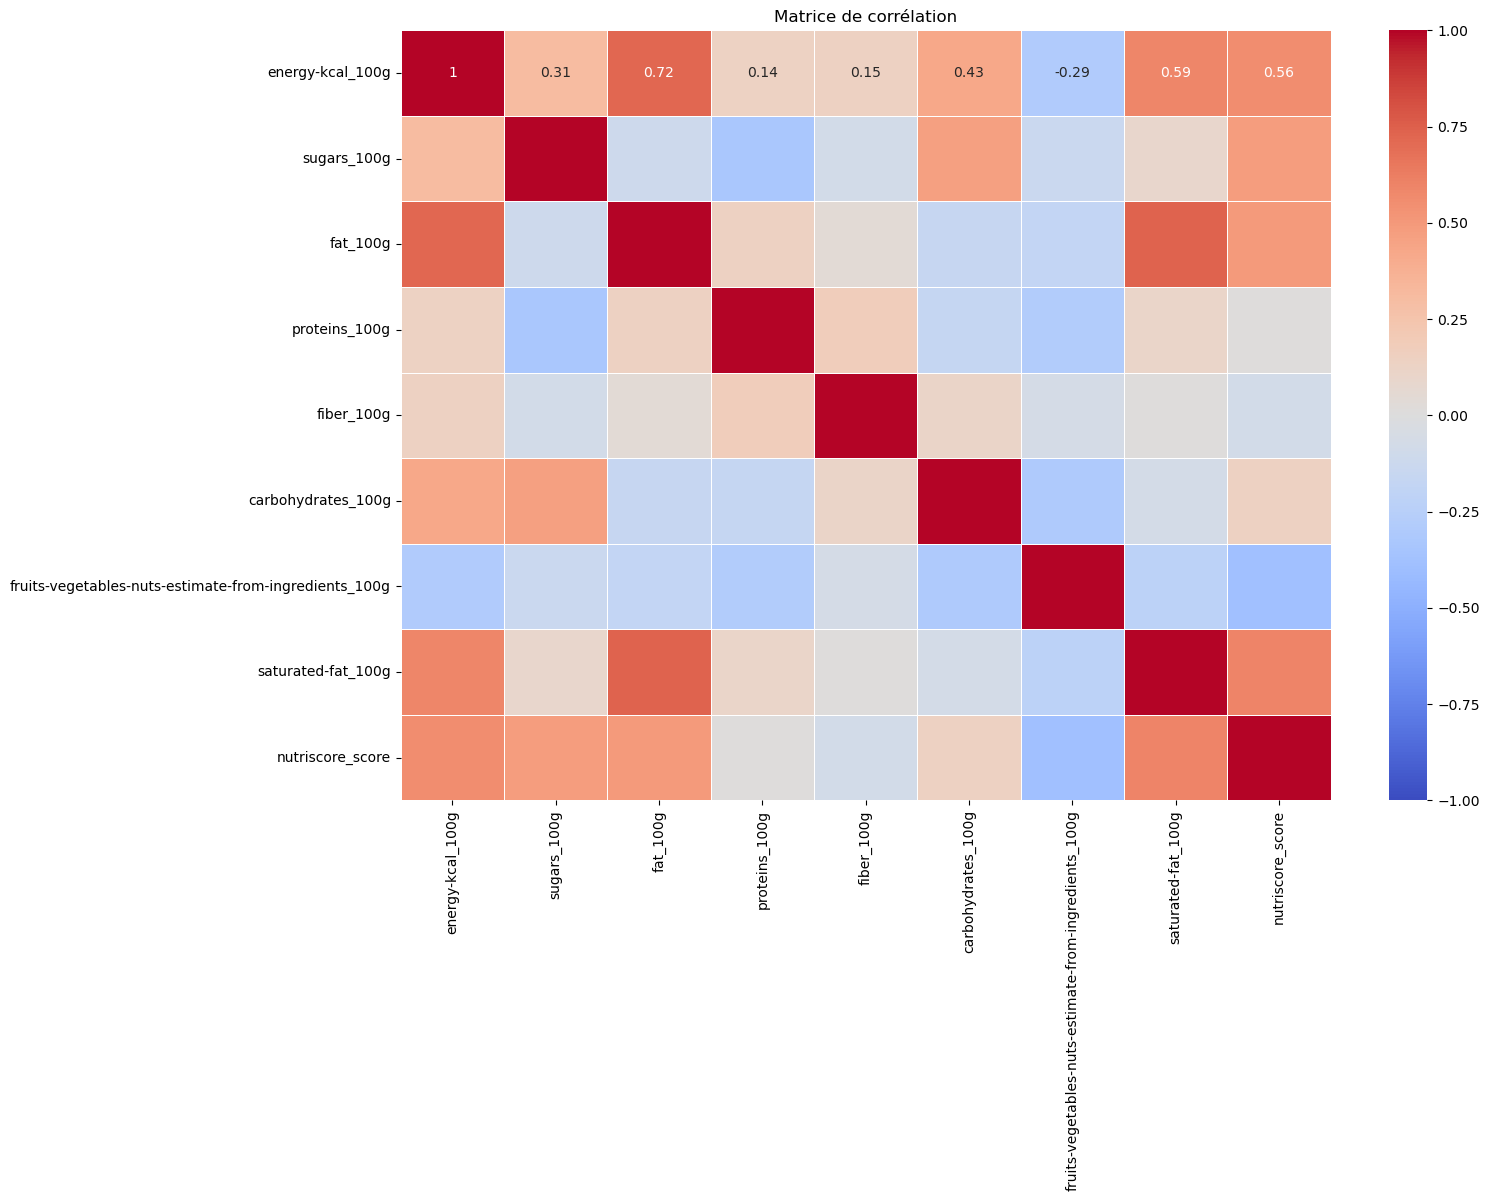

In [197]:
correlation_matrix = df[['energy-kcal_100g', 'sugars_100g','fat_100g','proteins_100g','fiber_100g','carbohydrates_100g','fruits-vegetables-nuts-estimate-from-ingredients_100g','saturated-fat_100g','nutriscore_score',]].corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, linewidths=.5)
plt.title('Matrice de corrélation')
plt.show()

## Graphes

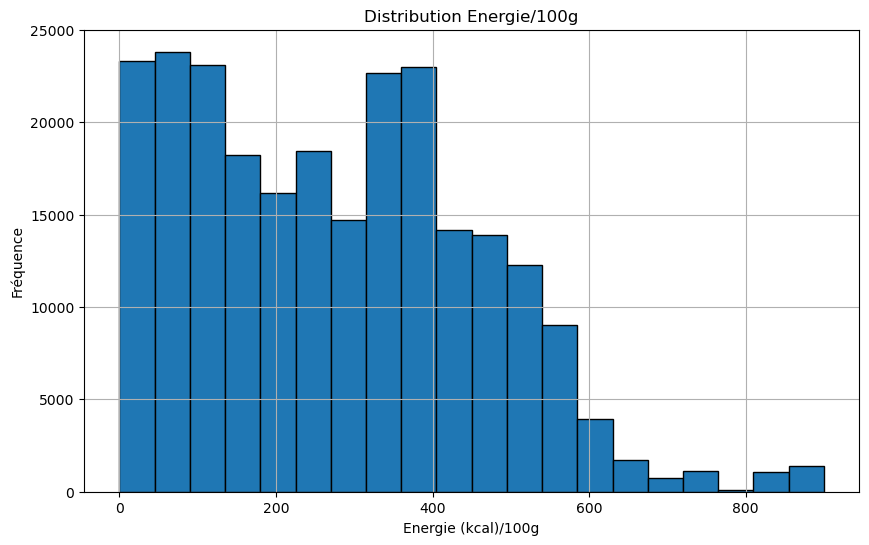

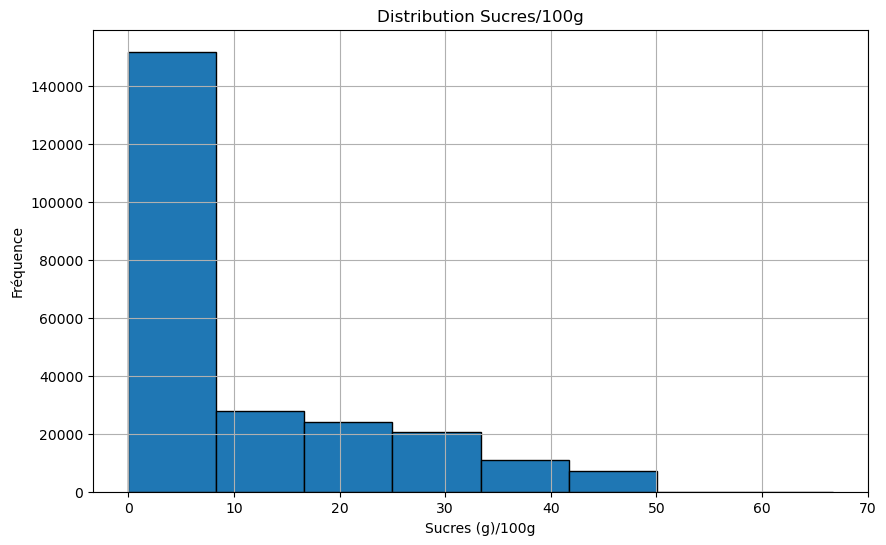

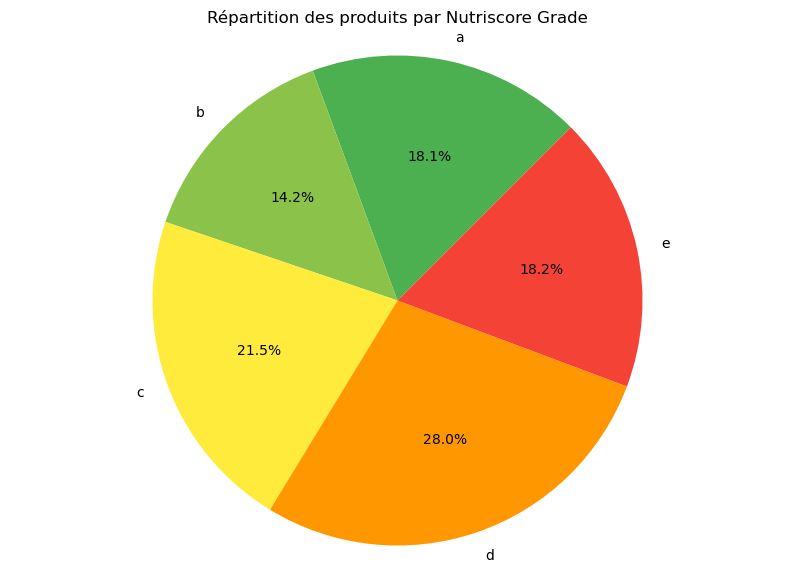

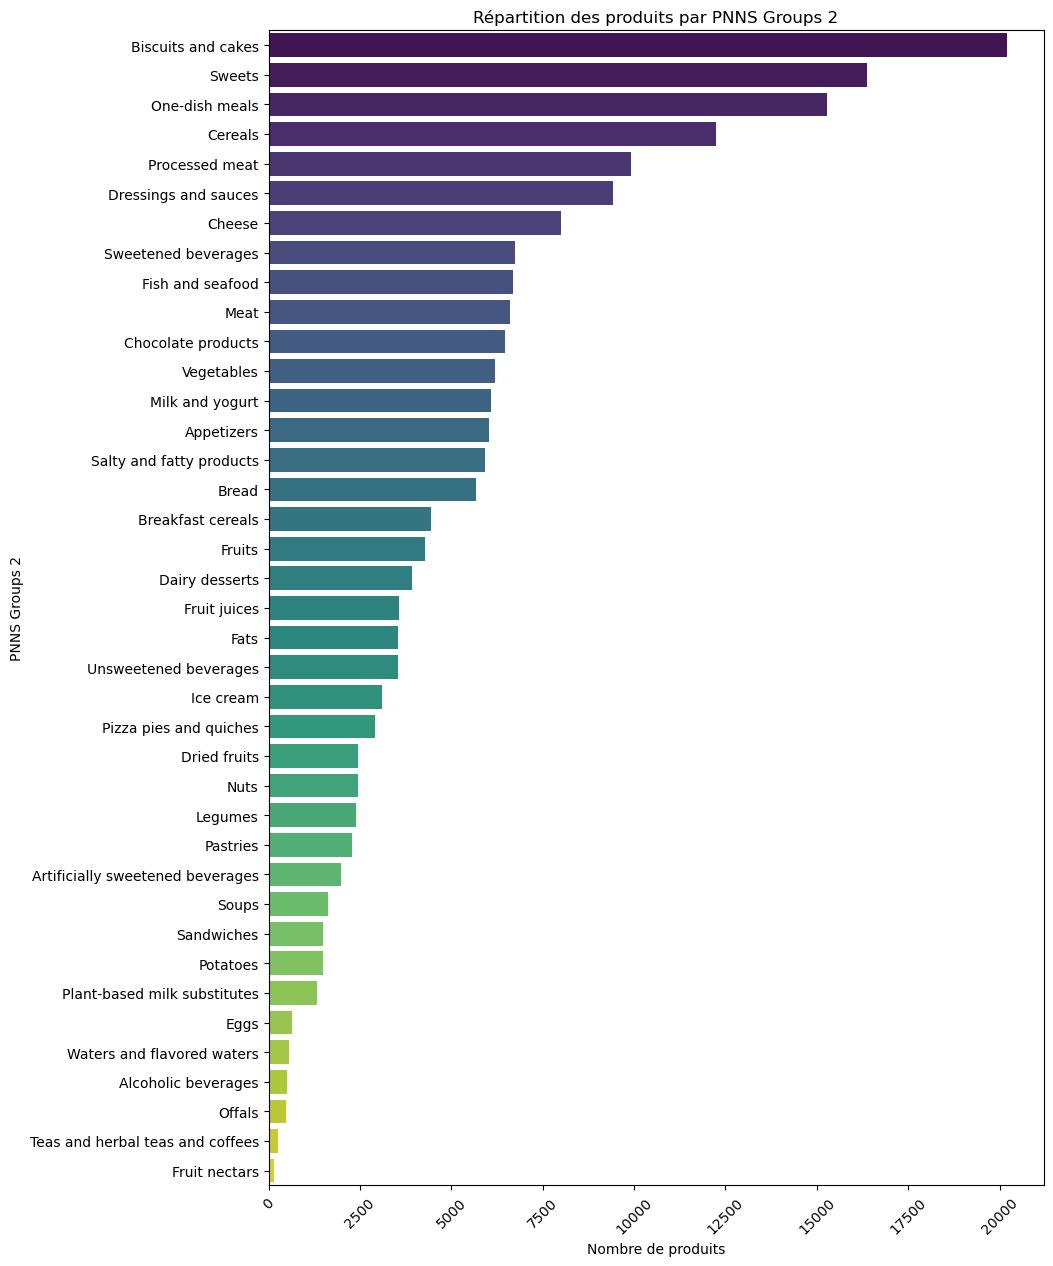

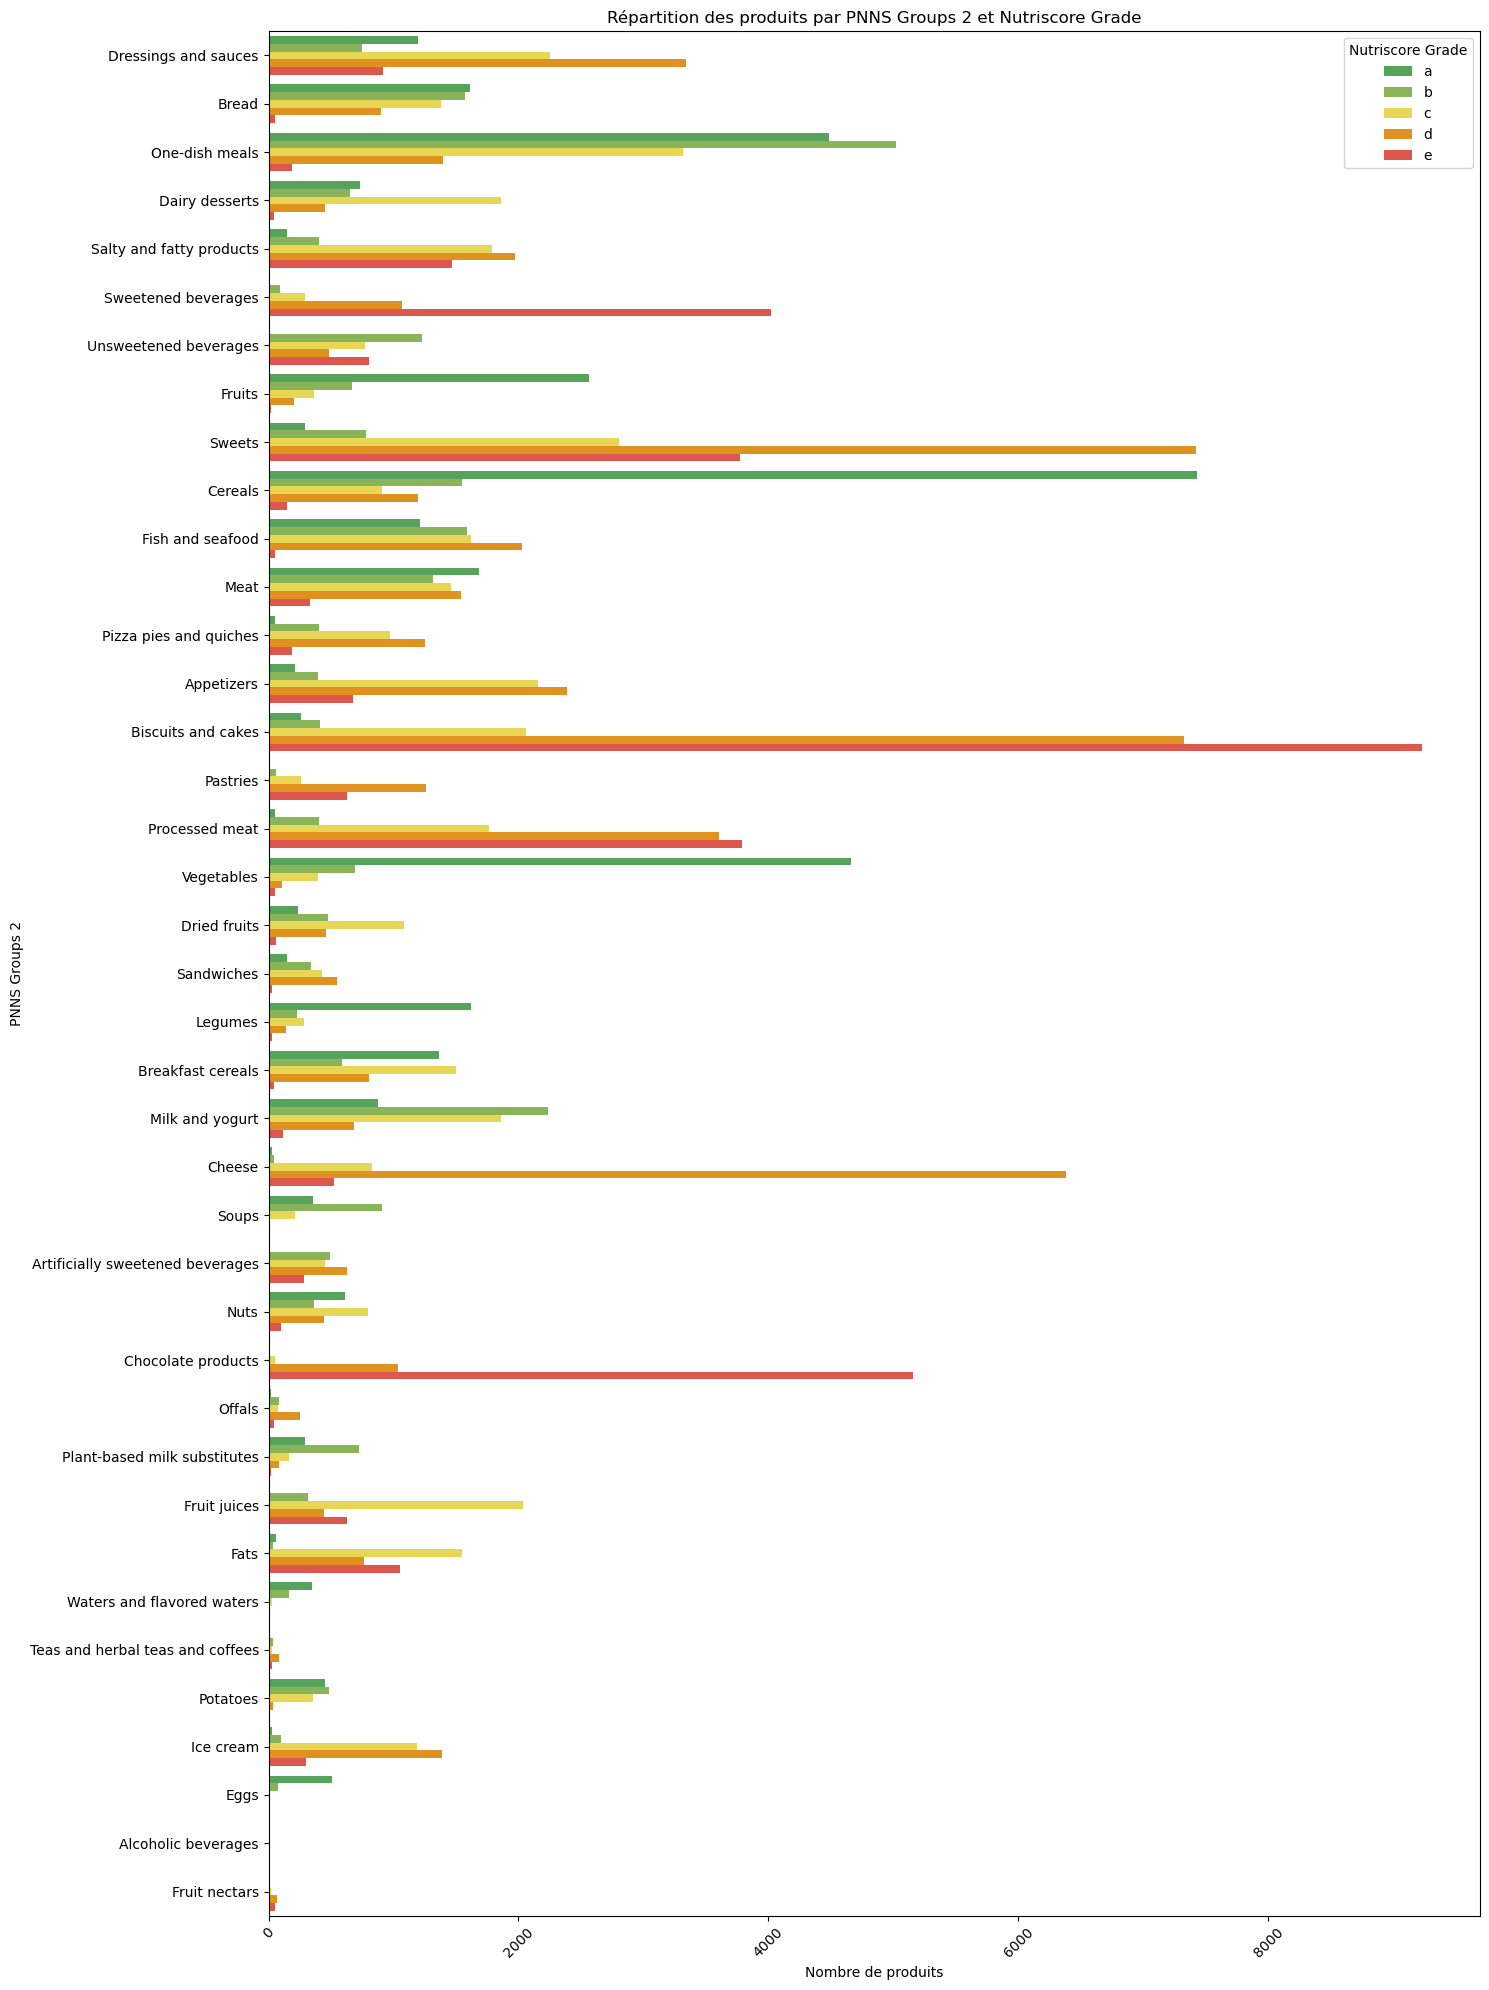

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

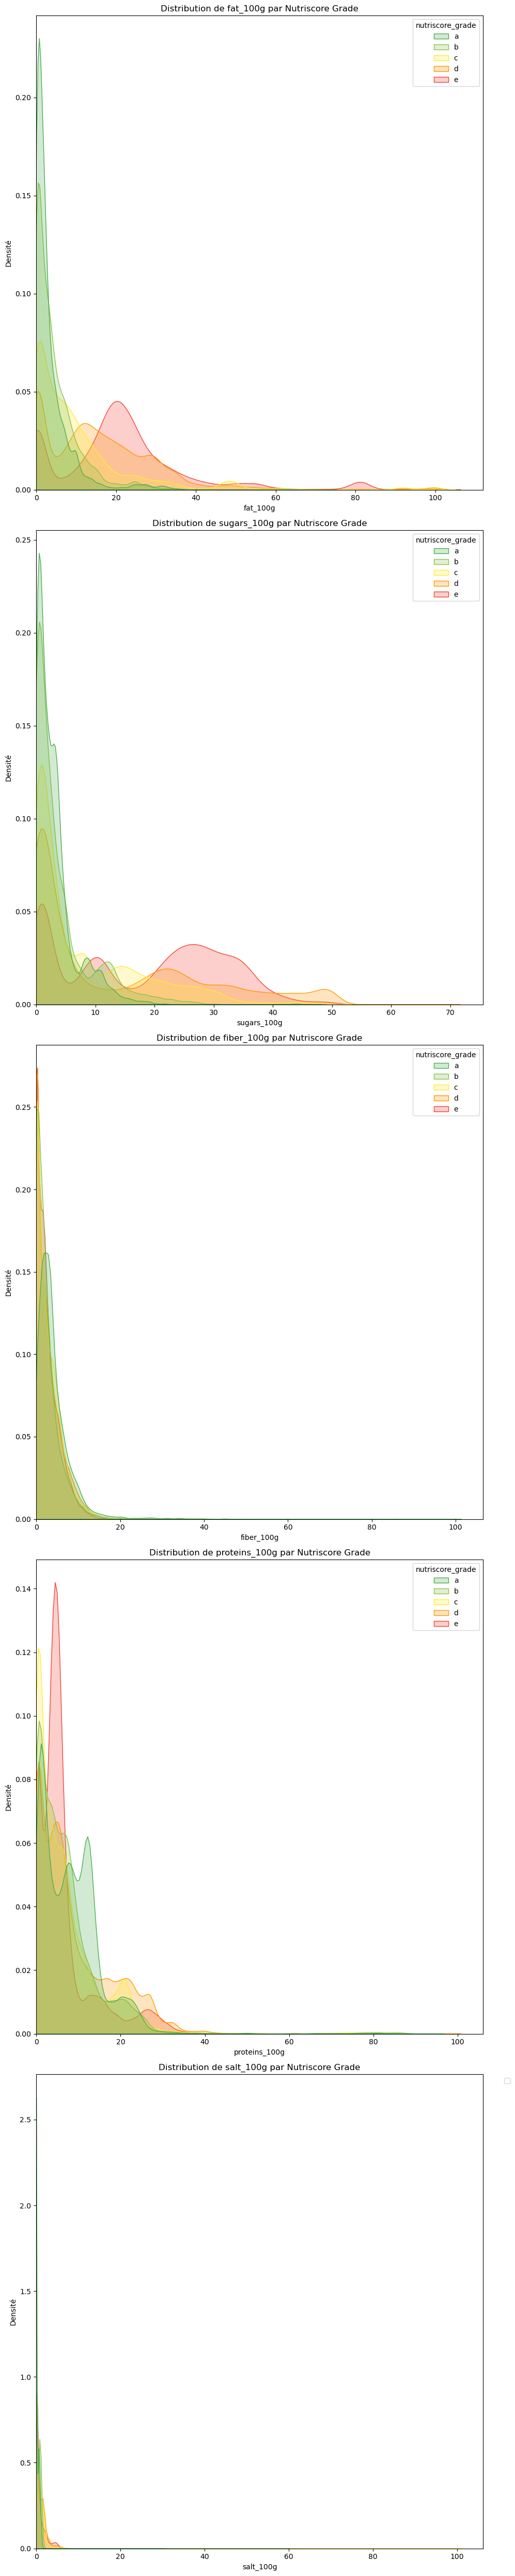

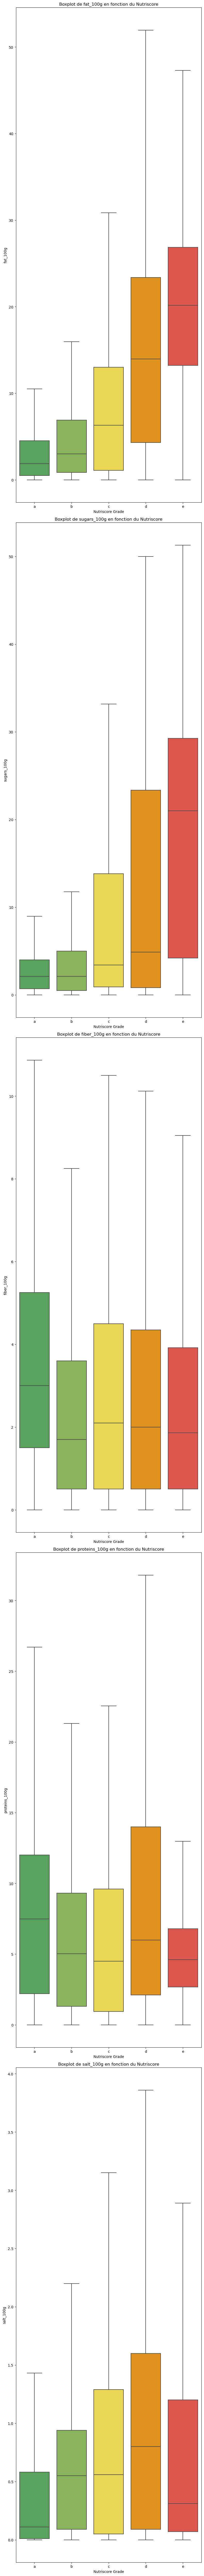

In [199]:
# Définir les variables à analyser
variables = ['fat_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g']

# Définir la palette de couleurs pour les grades Nutri-Score
palette_colors = {
    'a': '#4CAF50',  # Vert foncé
    'b': '#8BC34A',  # Vert clair
    'c': '#FFEB3B',  # Jaune
    'd': '#FF9800',  # Orange
    'e': '#F44336'   # Rouge
}

# La fonction generate_plots définie précédemment
def generate_plots(df, variables, palette_colors):
    """
    Génère différents types de graphiques pour les données fournies dans l'ordre spécifié.
    
    Parameters:
    - df: DataFrame contenant les données.
    - variables: Liste des variables à analyser pour les boxplots et les courbes de densité.
    - palette_colors: Dictionnaire définissant les couleurs pour chaque grade Nutri-Score.
    
    Returns:
    - None
    """
    
    # Remplacer les valeurs infinies par NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Filtrer les grades pour exclure "unknown" et "not-applicable"
    df_filtre = df[~df['nutriscore_grade'].isin(['unknown', 'not-applicable'])]

    # Obtenir les grades Nutri-Score uniques, les convertir en chaînes, et les trier en ordre alphabétique
    grades_ordonnes = sorted(df_filtre['nutriscore_grade'].dropna().astype(str).unique())

    # Créer une palette adaptée aux grades présents dans les données
    palette = {grade: palette_colors.get(grade, '#C0C0C0') for grade in grades_ordonnes}

    # --- 1. Histogrammes ---
    # Histogramme pour 'energy-kcal_100g'
    plt.figure(figsize=(10, 6))
    plt.hist(df['energy-kcal_100g'].dropna(), edgecolor='black', bins=20)
    plt.xlabel('Energie (kcal)/100g')
    plt.ylabel('Fréquence')
    plt.title('Distribution Energie/100g')
    plt.grid(True)
    plt.show()

    # Histogramme pour 'sugars_100g'
    plt.figure(figsize=(10, 6))
    plt.hist(df['sugars_100g'].dropna(), edgecolor='black', bins=8)
    plt.xlabel('Sucres (g)/100g')
    plt.ylabel('Fréquence')
    plt.title('Distribution Sucres/100g')
    plt.grid(True)
    plt.show()

    # --- 2. Camembert ---
    # Obtenir les comptes des grades Nutri-Score
    score_counts = df_filtre['nutriscore_grade'].value_counts()

    # Trier les counts en fonction de l'ordre alphabétique des grades
    score_counts_ordonnes = score_counts[grades_ordonnes]

    # Créer une liste de couleurs correspondant aux grades présents dans les données
    colors = [palette.get(grade, '#C0C0C0') for grade in grades_ordonnes]

    plt.figure(figsize=(10, 7))
    plt.pie(score_counts_ordonnes, labels=grades_ordonnes, autopct='%1.1f%%', startangle=45, colors=colors)
    plt.title('Répartition des produits par Nutriscore Grade')
    plt.axis('equal')  # Assure que le camembert est un cercle
    plt.show()

    # --- 3. Countplot général ---
    comptages = df['pnns_groups_2'].value_counts()
    plt.figure(figsize=(10, 15))
    sns.countplot(data=df, y='pnns_groups_2', order=comptages.index, palette='viridis')
    plt.title('Répartition des produits par PNNS Groups 2')
    plt.ylabel('PNNS Groups 2')
    plt.xlabel('Nombre de produits')
    plt.xticks(rotation=45)
    plt.show()
    
    # --- 4. Countplot filtré avec Nutriscore Grade ---
    comptages = df_filtre['pnns_groups_2'].value_counts()
    plt.figure(figsize=(15, 20))
    sns.countplot(y='pnns_groups_2', hue='nutriscore_grade', data=df_filtre, palette=palette, hue_order=grades_ordonnes)
    plt.title('Répartition des produits par PNNS Groups 2 et Nutriscore Grade')
    plt.xlabel('Nombre de produits')
    plt.ylabel('PNNS Groups 2')
    plt.xticks(rotation=45)
    plt.legend(title='Nutriscore Grade')
    plt.tight_layout()
    plt.show()

    # --- 5. Courbes de Densité (KDE) ---
    plt.figure(figsize=(10, 50))  # Ajuster la taille de la figure (largeur, hauteur)
    for i, var in enumerate(variables, start=1):
        plt.subplot(len(variables), 1, i)  # Ajuster le nombre de lignes dynamiquement
        sns.kdeplot(data=df_filtre, x=var, hue='nutriscore_grade', fill=True, common_norm=False, hue_order=grades_ordonnes, palette=palette)
        plt.title(f'Distribution de {var} par Nutriscore Grade')
        plt.xlabel(var)
        plt.ylabel('Densité')
        plt.xlim(left=0)  # Forcer le début de l'axe x à 0
    plt.subplots_adjust(right=0.8, hspace=0.5)  # Ajustement horizontal et espace vertical
    plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # --- 6. Boxplots ---
    plt.figure(figsize=(8, 100))  # Ajuster la taille de la figure (largeur, hauteur)
    for i, var in enumerate(variables, start=1):
        plt.subplot(len(variables), 1, i)  # Ajuster le nombre de lignes dynamiquement
        sns.boxplot(x='nutriscore_grade', y=var, data=df_filtre, palette=palette, order=grades_ordonnes, showfliers=False)
        plt.title(f'Boxplot de {var} en fonction du Nutriscore')
        plt.xlabel('Nutriscore Grade')
        plt.ylabel(var)
    plt.tight_layout()
    plt.show()

# Appel de la fonction avec les données définies
generate_plots(df, variables, palette_colors)


# Timer

In [201]:
end_time = time.time()
execution_time = end_time - start_time

print(f"Temps d'exécution total du notebook : {execution_time:.4f} secondes")

Temps d'exécution total du notebook : 597.6336 secondes


In [202]:
zero_percentages = (df == 0).sum() / df.shape[0] * 100
nan_percentages = df.isna().sum() / df.shape[0] * 100
print("Pourcentage des valeurs égales à 0 :")
print(zero_percentages)
print("\nPourcentage des NaN :")
print(nan_percentages)

Pourcentage des valeurs égales à 0 :
code                                                     0.00
product_name                                             0.00
countries                                                0.00
nutriscore_score                                         4.31
nutriscore_grade                                         0.00
pnns_groups_1                                            0.00
pnns_groups_2                                            0.00
ecoscore_grade                                           0.00
energy-kcal_100g                                         1.26
fat_100g                                                 9.33
saturated-fat_100g                                      13.65
carbohydrates_100g                                       5.40
sugars_100g                                              9.05
fiber_100g                                              15.04
proteins_100g                                            7.39
salt_100g                        

In [203]:
df.isna().sum()

code                                                         0
product_name                                                 0
countries                                                    0
nutriscore_score                                         37338
nutriscore_grade                                          1028
pnns_groups_1                                            51814
pnns_groups_2                                            45545
ecoscore_grade                                               9
energy-kcal_100g                                             0
fat_100g                                                     0
saturated-fat_100g                                           0
carbohydrates_100g                                           0
sugars_100g                                                  0
fiber_100g                                                   0
proteins_100g                                                0
salt_100g                                              

In [204]:
df.head(30)

,code,product_name,countries,nutriscore_score,nutriscore_grade,pnns_groups_1,pnns_groups_2,ecoscore_grade,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
4,0000000000100,moutarde au moût de raisin,France,18.00,d,Fat and sauces,Dressings and sauces,c,271.31,8.20,2.20,29.00,22.00,0.00,5.10,4.60,0.00
33,0000000001663,Crème dessert chocolat,France,4.00,unknown,NaN,Dairy desserts,unknown,0.00,0.00,0.00,0.00,0.00,2.07,0.00,0.00,0.00
42,0000000002264,Baguette Poitevin,France,NaN,unknown,NaN,NaN,unknown,207.00,6.70,3.80,27.50,0.60,1.70,8.90,0.40,0.00
56,0000000003827,Suedois saumon,France,NaN,unknown,NaN,NaN,unknown,172.00,4.40,1.20,23.30,4.60,2.70,8.40,3.58,33.19
63,0000000004510,Salade shaker taboulé,France,NaN,unknown,NaN,NaN,unknown,114.00,8.10,0.90,5.70,1.40,1.70,3.90,0.31,23.02
67,0000000004794,Fromage blanc à la creme de marron,France,NaN,unknown,NaN,NaN,unknown,150.00,5.90,3.70,18.60,17.40,0.60,5.10,0.34,0.00
74,0000000005272,Sandwich solene céréales sicilien,France,NaN,unknown,NaN,NaN,unknown,213.00,5.40,0.80,26.11,1.48,2.70,7.05,4.69,52.57
76,0000000005470,BAguette bressan,France,-4.00,a,Cereals and potatoes,Bread,b,160.00,2.20,0.50,25.20,0.60,1.60,9.50,0.36,0.00
150,0000000031141,Moelleux au chocolat,"États-Unis, en:france",16.50,unknown,NaN,Biscuits and cakes,unknown,470.00,22.65,18.30,36.34,25.58,5.78,4.91,1.03,3.71
155,0000000034791,Fromage blanc à la crème de marron,"États-Unis, en:france",0.00,unknown,NaN,Dairy desserts,unknown,153.00,3.70,3.90,12.77,10.41,6.39,2.81,0.06,63.86


# tests

In [206]:
data_columns = ['energy-kcal_100g', 'sugars_100g','fat_100g','proteins_100g','fiber_100g','carbohydrates_100g','fruits-vegetables-nuts-estimate-from-ingredients_100g','saturated-fat_100g','nutriscore_score']

results = []
# Comparer chaque paire de colonnes
for i in range(len(data_columns)):
    for j in range(i + 1, len(data_columns)):
        col1 = data_columns[i]
        col2 = data_columns[j]
        
        # Obtenir les données des colonnes, en supprimant les NaN
        data1 = df[col1].dropna()
        data2 = df[col2].dropna()
        
        # Effectuer le test de Kruskal-Wallis
        stat, p_value = stats.kruskal(data1, data2)

        # Interprétation des résultats
        alpha = 0.08
        if p_value < alpha:
            result = f"Comparaison entre {col1} et {col2} : Rejeter l'hypothèse nulle (p = {p_value:.4f}). Les groupes ne proviennent pas de la même distribution."
        else:
            result = f"Comparaison entre {col1} et {col2} : Ne pas rejeter l'hypothèse nulle (p = {p_value:.4f}). Les groupes proviennent de la même distribution."
        
        results.append(result)

# Afficher les résultats
for result in results:
    print(result)

Comparaison entre energy-kcal_100g et sugars_100g : Rejeter l'hypothèse nulle (p = 0.0000). Les groupes ne proviennent pas de la même distribution.
Comparaison entre energy-kcal_100g et fat_100g : Rejeter l'hypothèse nulle (p = 0.0000). Les groupes ne proviennent pas de la même distribution.
Comparaison entre energy-kcal_100g et proteins_100g : Rejeter l'hypothèse nulle (p = 0.0000). Les groupes ne proviennent pas de la même distribution.
Comparaison entre energy-kcal_100g et fiber_100g : Rejeter l'hypothèse nulle (p = 0.0000). Les groupes ne proviennent pas de la même distribution.
Comparaison entre energy-kcal_100g et carbohydrates_100g : Rejeter l'hypothèse nulle (p = 0.0000). Les groupes ne proviennent pas de la même distribution.
Comparaison entre energy-kcal_100g et fruits-vegetables-nuts-estimate-from-ingredients_100g : Rejeter l'hypothèse nulle (p = 0.0000). Les groupes ne proviennent pas de la même distribution.
Comparaison entre energy-kcal_100g et saturated-fat_100g : Rejete

In [207]:
pd.set_option('display.float_format', '{:.2f}'.format)

# Afficher des statistiques descriptives
print(df.describe())

       nutriscore_score  energy-kcal_100g  fat_100g  saturated-fat_100g  \
count         205532.00         242870.00 242870.00           242870.00   
mean               8.48            276.20     11.64                5.16   
std                9.04            183.17     14.25                7.81   
min              -15.00              0.00      0.00                0.00   
25%                1.00            115.00      1.07                0.30   
50%                8.00            265.00      6.90                1.90   
75%               15.00            401.00     18.00                7.10   
max               40.00            900.00    100.00              100.00   

       carbohydrates_100g  sugars_100g  fiber_100g  proteins_100g  salt_100g  \
count           242870.00    242870.00   242870.00      242870.00  242870.00   
mean                24.22        10.29        3.17           7.65       1.06   
std                 22.46        12.60        3.95           8.79       3.78   
min 

In [208]:
df.head(30)

,code,product_name,countries,nutriscore_score,nutriscore_grade,pnns_groups_1,pnns_groups_2,ecoscore_grade,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
4,0000000000100,moutarde au moût de raisin,France,18.00,d,Fat and sauces,Dressings and sauces,c,271.31,8.20,2.20,29.00,22.00,0.00,5.10,4.60,0.00
33,0000000001663,Crème dessert chocolat,France,4.00,unknown,NaN,Dairy desserts,unknown,0.00,0.00,0.00,0.00,0.00,2.07,0.00,0.00,0.00
42,0000000002264,Baguette Poitevin,France,NaN,unknown,NaN,NaN,unknown,207.00,6.70,3.80,27.50,0.60,1.70,8.90,0.40,0.00
56,0000000003827,Suedois saumon,France,NaN,unknown,NaN,NaN,unknown,172.00,4.40,1.20,23.30,4.60,2.70,8.40,3.58,33.19
63,0000000004510,Salade shaker taboulé,France,NaN,unknown,NaN,NaN,unknown,114.00,8.10,0.90,5.70,1.40,1.70,3.90,0.31,23.02
67,0000000004794,Fromage blanc à la creme de marron,France,NaN,unknown,NaN,NaN,unknown,150.00,5.90,3.70,18.60,17.40,0.60,5.10,0.34,0.00
74,0000000005272,Sandwich solene céréales sicilien,France,NaN,unknown,NaN,NaN,unknown,213.00,5.40,0.80,26.11,1.48,2.70,7.05,4.69,52.57
76,0000000005470,BAguette bressan,France,-4.00,a,Cereals and potatoes,Bread,b,160.00,2.20,0.50,25.20,0.60,1.60,9.50,0.36,0.00
150,0000000031141,Moelleux au chocolat,"États-Unis, en:france",16.50,unknown,NaN,Biscuits and cakes,unknown,470.00,22.65,18.30,36.34,25.58,5.78,4.91,1.03,3.71
155,0000000034791,Fromage blanc à la crème de marron,"États-Unis, en:france",0.00,unknown,NaN,Dairy desserts,unknown,153.00,3.70,3.90,12.77,10.41,6.39,2.81,0.06,63.86


Proportion de variance expliquée par chaque composant principal:
Composant Principal 1: 0.3302
Composant Principal 2: 0.2306
Composant Principal 3: 0.1511
Composant Principal 4: 0.1272
Composant Principal 5: 0.0986
Composant Principal 6: 0.0461
Composant Principal 7: 0.0162


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


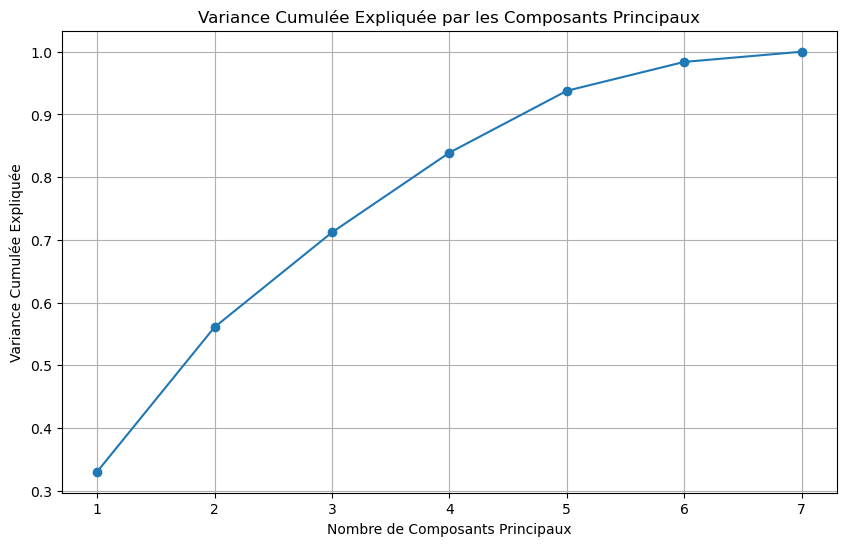

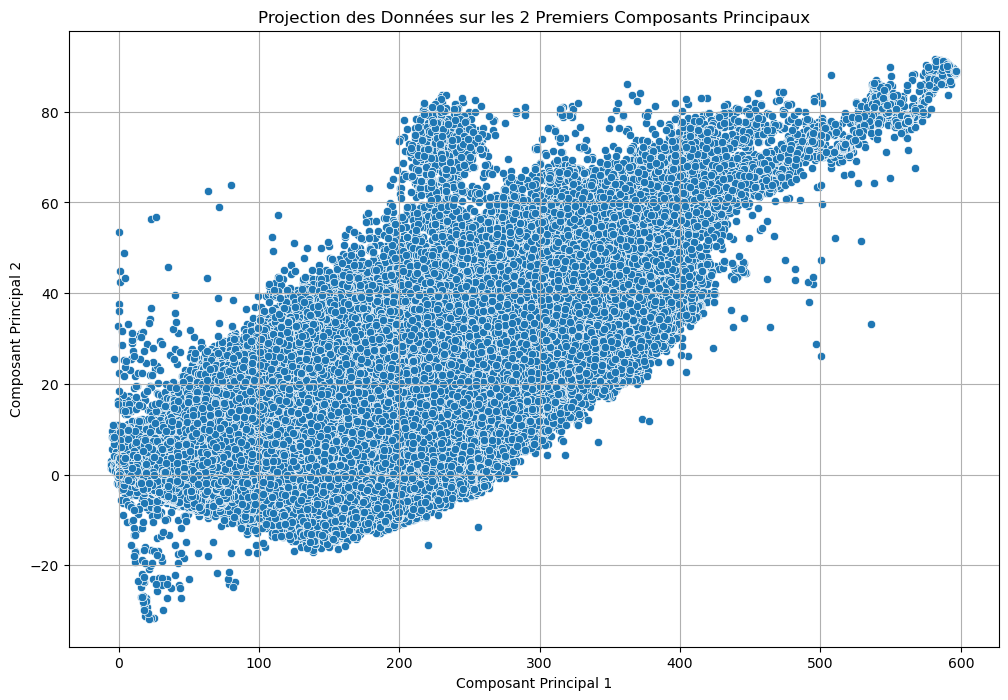

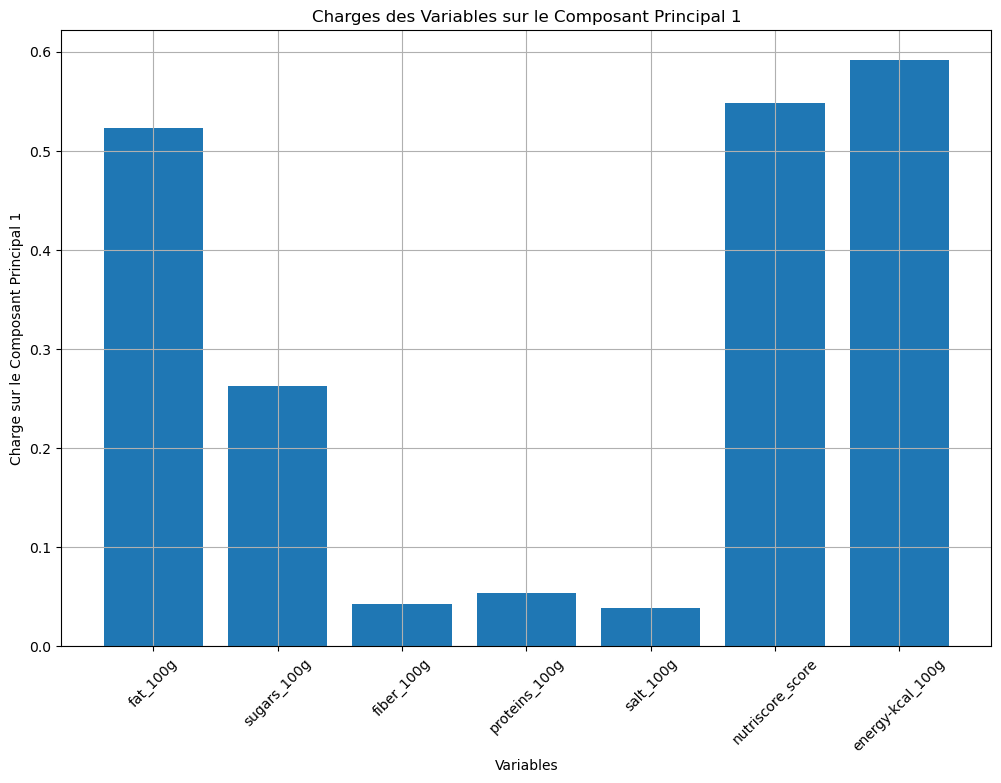

In [217]:
# Définir les colonnes à analyser
data_columns = ['fat_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g','nutriscore_score','energy-kcal_100g']

# Sélectionner les données
data = df[data_columns].dropna()

# Standardiser les données
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Calculer l'ACP
pca = PCA(n_components=len(data_columns))
pca.fit(data_scaled)

# Obtenir les composantes principales et les valeurs expliquées
components = pca.components_
explained_variance = pca.explained_variance_ratio_

# Afficher la proportion de variance expliquée par chaque composant principal
print("Proportion de variance expliquée par chaque composant principal:")
for i, var in enumerate(explained_variance, start=1):
    print(f"Composant Principal {i}: {var:.4f}")

# Créer un DataFrame des résultats de l'ACP
pca_results = pd.DataFrame(data=pca.transform(data), columns=[f'PC{i+1}' for i in range(len(data_columns))])

# Visualiser la variance expliquée par chaque composant
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance.cumsum(), marker='o')
plt.xlabel('Nombre de Composants Principaux')
plt.ylabel('Variance Cumulée Expliquée')
plt.title('Variance Cumulée Expliquée par les Composants Principaux')
plt.grid(True)
plt.show()

# Visualiser les premières composantes principales
plt.figure(figsize=(12, 8))
sns.scatterplot(x=pca_results['PC1'], y=pca_results['PC2'])
plt.xlabel('Composant Principal 1')
plt.ylabel('Composant Principal 2')
plt.title('Projection des Données sur les 2 Premiers Composants Principaux')
plt.grid(True)
plt.show()

# Optionnel: Visualiser les charges des variables sur les composantes principales
plt.figure(figsize=(12, 8))
plt.bar(range(len(data_columns)), pca.components_[0])
plt.xlabel('Variables')
plt.ylabel('Charge sur le Composant Principal 1')
plt.title('Charges des Variables sur le Composant Principal 1')
plt.xticks(ticks=range(len(data_columns)), labels=data_columns, rotation=45)
plt.grid(True)
plt.show()
